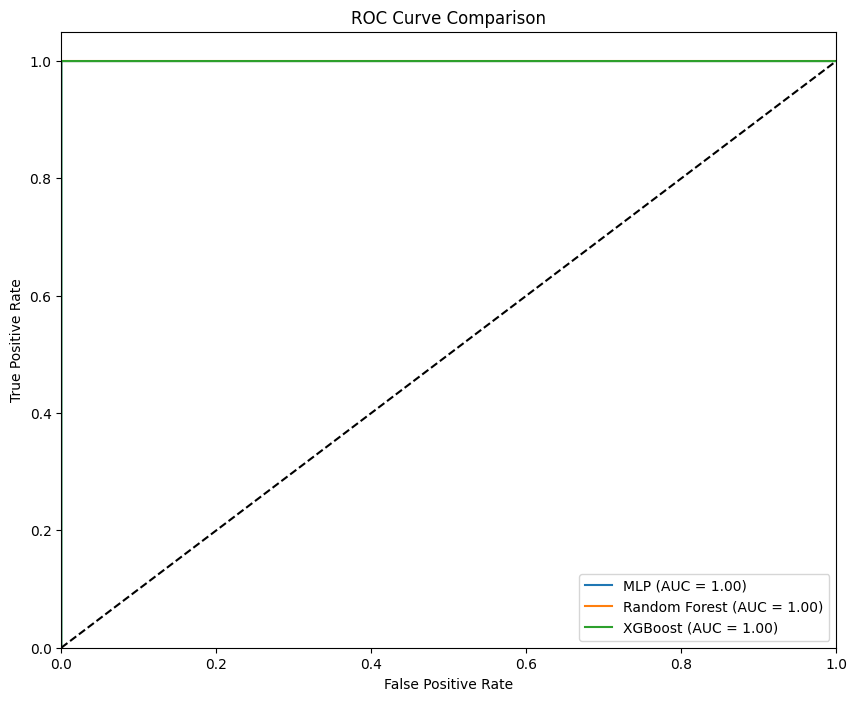

Model Comparison Results:

MLP:
  Accuracy: 1.0000
  F1 Score: 0.9998
  AUC: 1.0000
  Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (117,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 300, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}

Random Forest:
  Accuracy: 1.0000
  F1 Score: 1.0000
  AUC: 1.0000
  Best Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 174, 'n_jo

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

# Load the dataset
data = pd.read_csv('malware_BinaryImbalanced.csv')

# Select relevant columns and preprocess
cols = ['classification', 'os', 'usage_counter', 'prio', 'static_prio', 'normal_prio', 'vm_pgoff', 
        'vm_truncate_count', 'task_size', 'map_count', 'hiwater_rss', 'total_vm', 'shared_vm',
        'exec_vm', 'reserved_vm', 'nr_ptes', 'nvcsw', 'nivcsw', 'signal_nvcsw']
df = data[cols]
df = df.rename(columns=lambda x: x.strip())
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col].fillna(df[col].mean(), inplace=True)
df['classification'] = df['classification'].astype('category').cat.codes
df_num = pd.get_dummies(df, columns=['os'], drop_first=True)

# Split and scale the data
X = df_num.drop('classification', axis=1)
y = df_num['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
mlp = MLPClassifier(max_iter=300)
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define hyperparameter distributions for RandomizedSearchCV
mlp_params = {
    'hidden_layer_sizes': [(randint(50, 150).rvs(),), (randint(50, 150).rvs(), randint(50, 150).rvs())],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd']
}

rf_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

xgb_params = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Randomized Search for MLP
mlp_random = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=3, random_state=42, scoring='f1', n_jobs=-1)
mlp_random.fit(X_train_scaled, y_train)
mlp_best = mlp_random.best_estimator_

# Randomized Search for Random Forest
rf_random = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3, random_state=42, scoring='f1', n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)
rf_best = rf_random.best_estimator_

# Randomized Search for XGBoost
xgb_random = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, random_state=42, scoring='f1', n_jobs=-1)
xgb_random.fit(X_train_scaled, y_train)
xgb_best = xgb_random.best_estimator_

# Predictions and Metrics
models = {'MLP': mlp_best, 'Random Forest': rf_best, 'XGBoost': xgb_best}
results = {}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'AUC': auc_score, 'Best Parameters': model.get_params()}

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

# Display Results
print("Model Comparison Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        if metric != 'Best Parameters':
            print(f"  {metric}: {value:.4f}")
        else:
            print(f"  Best Parameters: {value}")